# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [1]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 57 kB 232 kB/s 


In [2]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:02<00:00, 33.1MB/s]


In [3]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [4]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

This method reads a series of strings and uses them to build it's dictionary mapping words to integers. It will only use the `num_words` most frequent words in this dictionary.

**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

This method converts a list of strings and converts them into a sequence of integers representing that string in the language of the tokenizers dictionary created by `fit_on_texts`

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

`pad_sequences` ensures all sequences in a list are the same length by zero-padding the front of any sequences shorter than the longest sequence with enough zeros to make them equal in length.


We Require this function to transform each input to have the same shape (length), and ensure that longer reviews are shortened to a length of `max_len`

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.



In [5]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [6]:
print(messages_train[6])
print("Length:", len(messages_train[6]))
print("Maximum:", max(messages_train[6]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  405    3  174    4
  646  150   16   57  340    4   32  321    4   48    6  166   20   71
    1  164   66   43   22   67  816   12   46    6   54  111   38   64
    1  310  286   23    3  973    2   57    1  446    6  381   11   19
   13  522   31 1708    9   13    1   61   19   12   28  123  522    2
    1 

The structure of the input is as expected. It is zero padded to be 200=`max_len` tokens long, and has a maximum of 1708, which is less than 2000=`max_vocab`. 

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [7]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

em = Embed(100, 200)
x = jn.array([1, 2, 3])
print(em.w.value[x].shape)

(3, 200)


**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

`__init__` creates the weight matrix self.w which is used to embed one-hot encodings into a lower-dimensional space.

If a sentence were passed to the module using `__call__` each word in the input x is converted to it's "latent space" representation. Note that matrix multiplication of a one hot encoded matrix is the same as simply selecting the row of the matrix at the index of the one hot encode

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

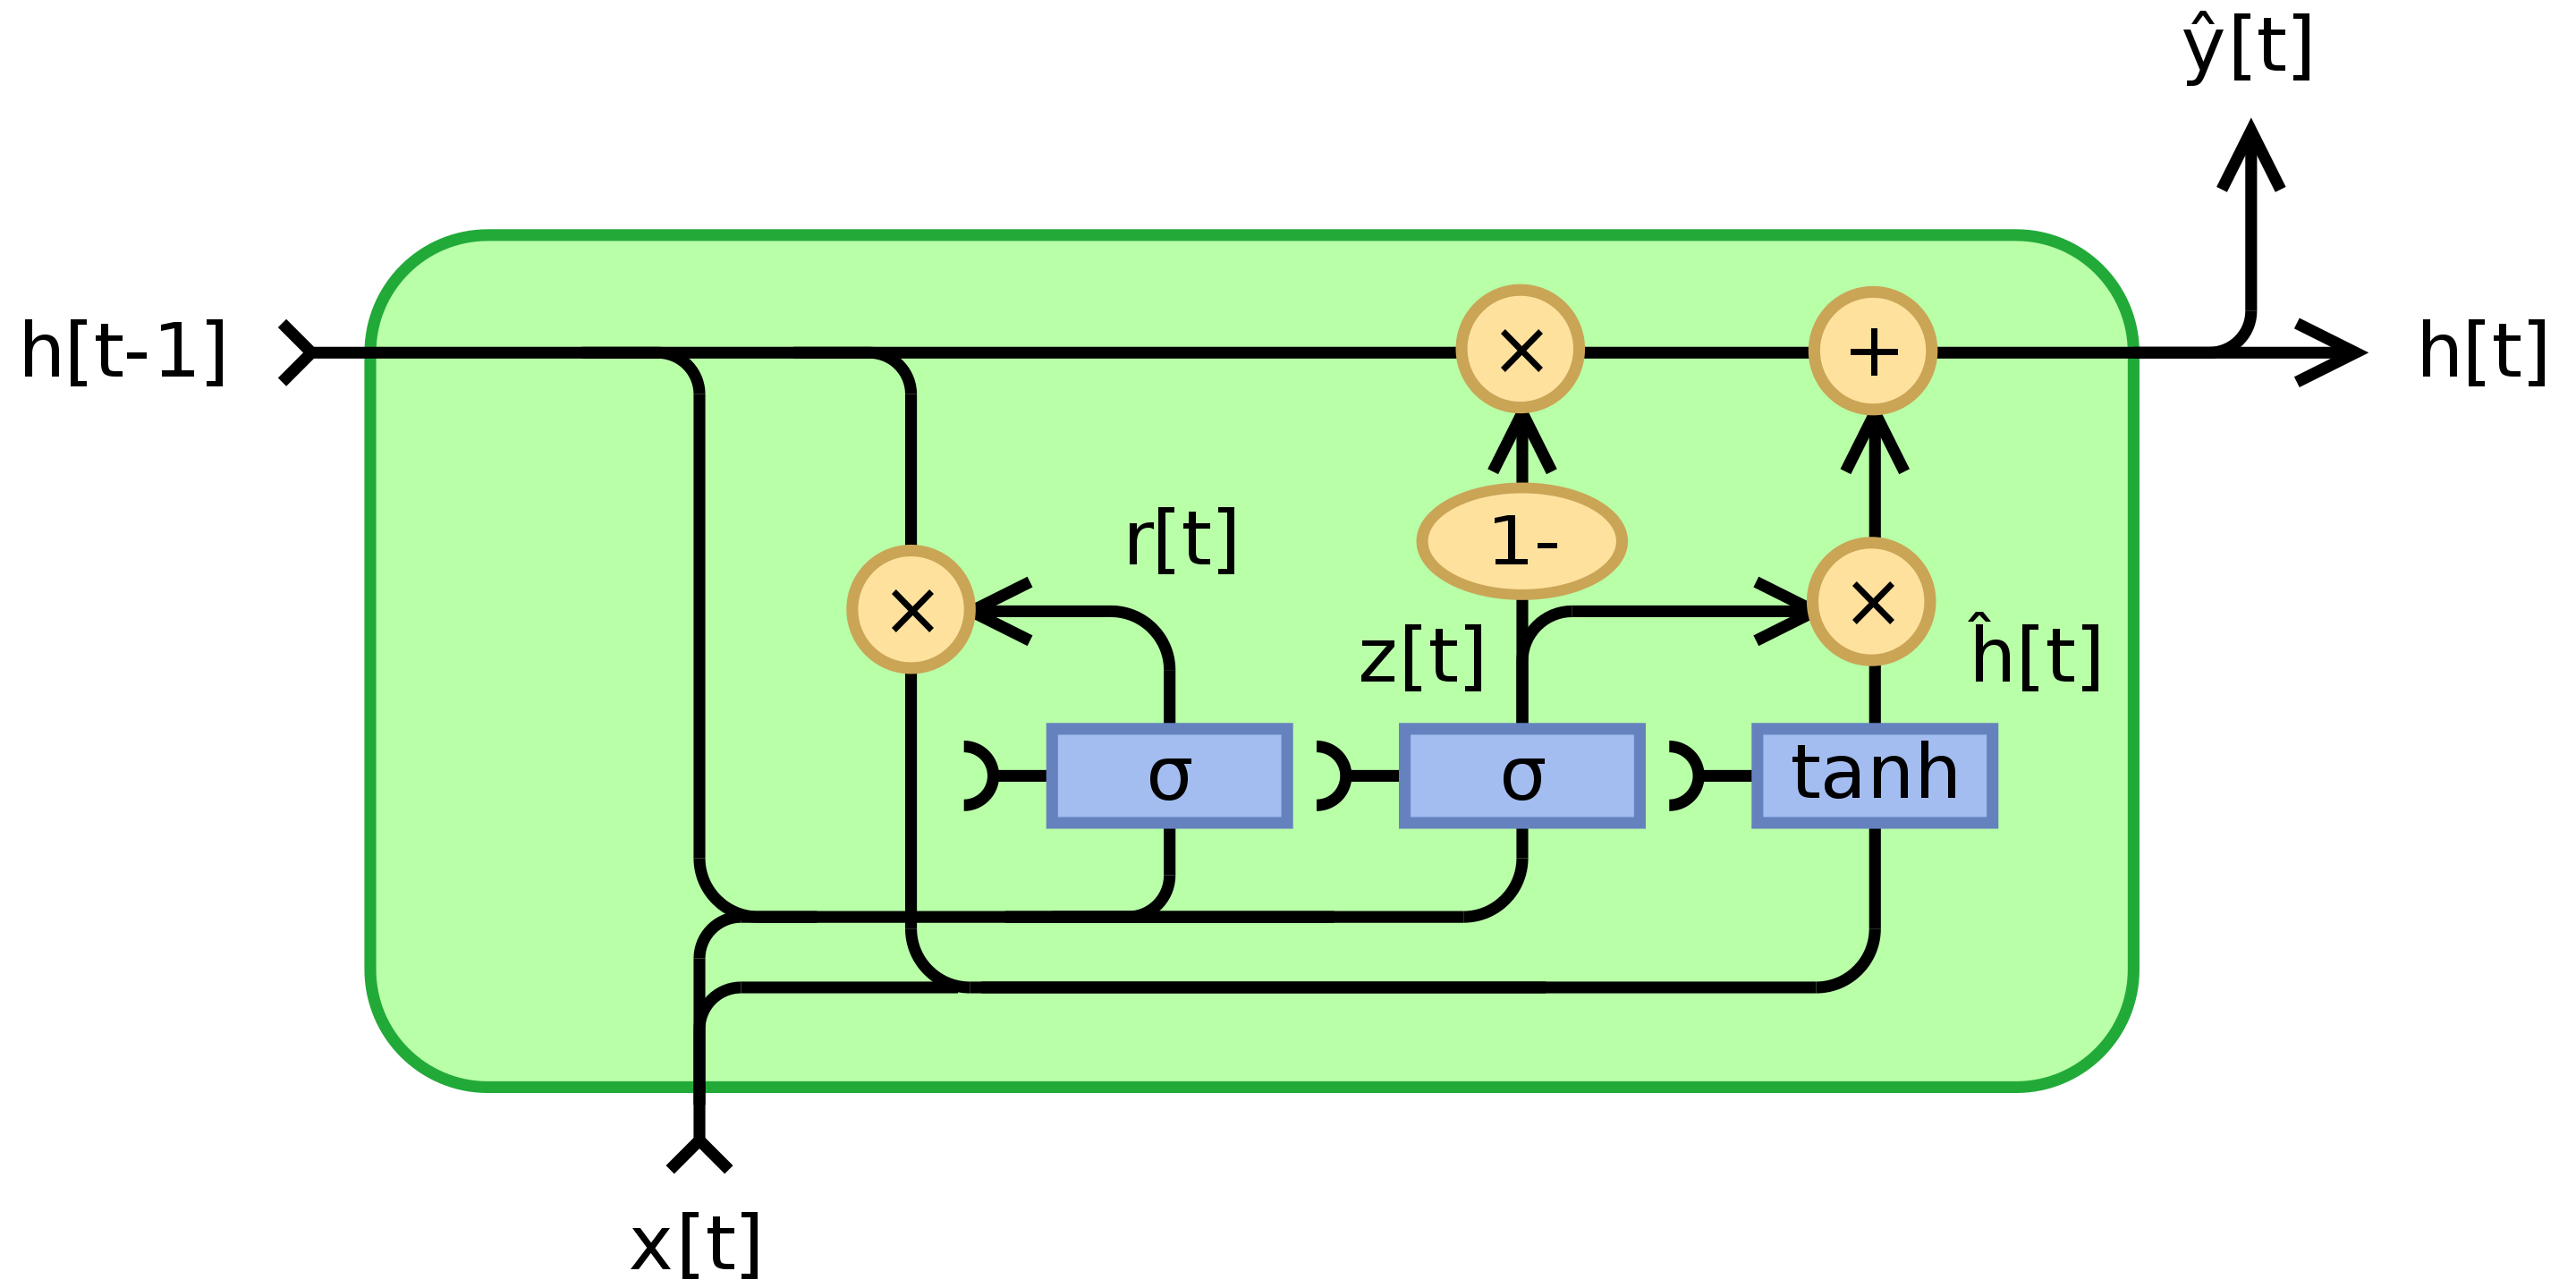

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [8]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            update_gate = objax.functional.sigmoid( ( x @ self.update_w ) + ( state @ self.update_u ) + self.update_b )

            reset_gate = objax.functional.sigmoid( ( x @ self.reset_w ) + ( state @ self.reset_u ) + self.reset_b )

            output_gate = objax.functional.tanh( ( x @ self.output_w ) + ( ( reset_gate * state ) @ self.output_u ) + self.output_b )

            return (1-update_gate) * state + (update_gate) * output_gate, 0

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval \{$1,...,max\_vocab$\} of length max_len. 
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [9]:
# fill this in:
gru_rnn = objax.nn.Sequential([
    Embed(max_len, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [10]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       13472


**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [11]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [12]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())

The next function is a helper for computing the accuracy.

In [13]:

def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [14]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [15]:

def train(EVAL_OP=eval_op, TRAIN_OP=train_op, EPOCHS=num_epochs, BATCH=batch_size, LEARNING_RATE=learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
    avg_train_loss = 0
    avg_val_loss = 0
    train_acc = 0
    val_acc = 0

    train_indices = np.arange(len(training_data[0]))
    np.random.shuffle(train_indices)
    for it in range(0, training_data[0].shape[0], BATCH):
        batch = train_indices[it:it+BATCH]
        avg_train_loss += float(TRAIN_OP(training_data[0][batch], training_data[1][batch], LEARNING_RATE)[0]) * len(batch)
        train_prediction = EVAL_OP(training_data[0][batch]).argmax(1)
        train_acc += (np.array(train_prediction).flatten() == training_data[1][batch]).sum()
    train_acc_epoch.append(train_acc/training_data[0].shape[0])
    avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

    val_indices = np.arange(len(validation_data[0]))
    np.random.shuffle(val_indices)
    for it in range(0, validation_data[0].shape[0], BATCH):
        batch = val_indices[it:it+BATCH]
        avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
        val_prediction = EVAL_OP(validation_data[0][batch]).argmax(1)
        val_acc += (np.array(val_prediction).flatten() == validation_data[1][batch]).sum()
    val_acc_epoch.append(val_acc/validation_data[0].shape[0])
    avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

    print('Epoch %04d Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/training_data[0].shape[0], avg_val_loss/validation_data[0].shape[0], 100*train_acc/training_data[0].shape[0], 100*val_acc/validation_data[0].shape[0]))

  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

Epoch 0001 Training Loss 172.97 Validation Loss 172.18 Training Accuracy 53.30 Validation Accuracy 54.18
Epoch 0002 Training Loss 172.05 Validation Loss 170.70 Training Accuracy 55.15 Validation Accuracy 56.32
Epoch 0003 Training Loss 170.31 Validation Loss 168.11 Training Accuracy 57.91 Validation Accuracy 58.36
Epoch 0004 Training Loss 168.69 Validation Loss 166.40 Training Accuracy 58.87 Validation Accuracy 59.84
Epoch 0005 Training Loss 166.28 Validation Loss 161.83 Training Accuracy 61.06 Validation Accuracy 62.72
Epoch 0006 Training Loss 163.69 Validation Loss 153.46 Training Accuracy 62.80 Validation Accuracy 66.82
Epoch 0007 Training Loss 161.77 Validation Loss 152.60 Training Accuracy 63.84 Validation Accuracy 67.66
Epoch 0008 Training Loss 159.31 Validation Loss 152.04 Training Accuracy 65.17 Validation Accuracy 68.52
Epoch 0009 Training Loss 160.20 Validation Loss 165.00 Training Accuracy 64.97 Validation Accuracy 61.36
Epoch 0010 Training Loss 156.56 Validation Loss 149.63 

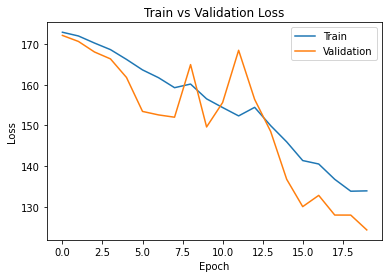

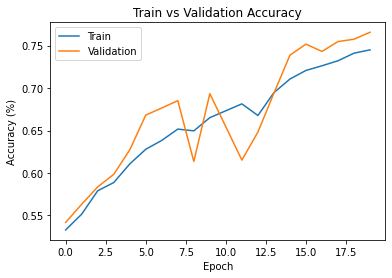

In [16]:
train()

In [17]:
predict = objax.Jit(lambda x: objax.functional.softmax(gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))), gru_rnn.vars()) 
test_prediction = predict(test_data[0]).argmax(1)
accuracy = (np.array(test_prediction).flatten() == test_data[1]).sum()
print(100 * accuracy / test_data[0].shape[0])

76.12


generalization gap is 73.86 - 73.32 = 0.54% which is very low

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [18]:
gru_rnn2 = objax.nn.Sequential([
    Embed(max_len, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [19]:
opt2 = objax.optimizer.Adam( gru_rnn2.vars() )

In [20]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op2(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op2 = objax.Jit(train_op2)
eval_op2 = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [21]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [22]:
# See solution to question 11. The function is reused for training purposes.

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

Epoch 0001 Training Loss 157.34 Validation Loss 128.97 Training Accuracy 63.23 Validation Accuracy 75.08
Epoch 0002 Training Loss 131.31 Validation Loss 130.33 Training Accuracy 74.44 Validation Accuracy 75.86
Epoch 0003 Training Loss 131.31 Validation Loss 125.52 Training Accuracy 74.03 Validation Accuracy 76.04
Epoch 0004 Training Loss 129.75 Validation Loss 124.70 Training Accuracy 74.39 Validation Accuracy 75.64
Epoch 0005 Training Loss 128.24 Validation Loss 128.59 Training Accuracy 74.75 Validation Accuracy 74.60
Epoch 0006 Training Loss 129.80 Validation Loss 127.97 Training Accuracy 74.25 Validation Accuracy 75.08
Epoch 0007 Training Loss 129.50 Validation Loss 125.44 Training Accuracy 74.31 Validation Accuracy 75.38
Epoch 0008 Training Loss 126.61 Validation Loss 122.98 Training Accuracy 75.11 Validation Accuracy 76.02
Epoch 0009 Training Loss 125.68 Validation Loss 121.55 Training Accuracy 75.49 Validation Accuracy 76.46
Epoch 0010 Training Loss 121.67 Validation Loss 119.13 

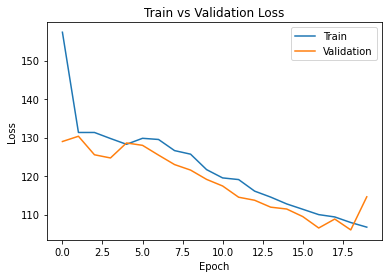

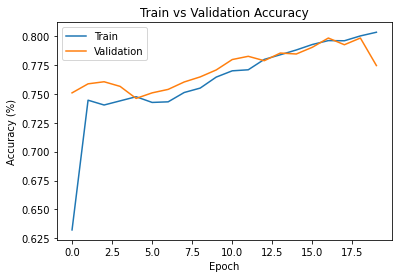

In [24]:
train(EVAL_OP=eval_op2, TRAIN_OP=train_op2)

In [28]:
predict = objax.Jit(lambda x: objax.functional.softmax(gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))), gru_rnn2.vars()) 
test_prediction = predict(test_data[0]).argmax(1)
accuracy = (np.array(test_prediction).flatten() == test_data[1]).sum()
print(100 * accuracy / test_data[0].shape[0])

77.58


Generalization gap is 80.32 - 77.58 = 2.74%

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

Adam works by storing an individual learning rate for each parameter, and using momentum. In comparison to SGD, it converges quicker and produces a better peak accuracy.

# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [25]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
    Embed(max_len, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [44]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam( gru_rnn3.vars() )

You will also need the following functions.

In [45]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op3(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op3 = objax.Jit(train_op3)
eval_op3 = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [46]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [47]:
# you code for the training loop should start here 
def train3(EVAL_OP=eval_op3, TRAIN_OP=train_op3, EPOCHS=num_epochs, BATCH=batch_size, LEARNING_RATE=learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []
  patience = 0
  max_validation = 0
  epoch = 0

  while patience < max_patience_window and epoch <= EPOCHS:
    avg_train_loss = 0
    avg_val_loss = 0
    train_acc = 0
    val_acc = 0

    train_indices = np.arange(len(training_data[0]))
    np.random.shuffle(train_indices)
    for it in range(0, training_data[0].shape[0], BATCH):
        batch = train_indices[it:it+BATCH]
        avg_train_loss += float(TRAIN_OP(training_data[0][batch], training_data[1][batch], LEARNING_RATE)[0]) * len(batch)
        train_prediction = EVAL_OP(training_data[0][batch]).argmax(1)
        train_acc += (np.array(train_prediction).flatten() == training_data[1][batch]).sum()
    train_acc_epoch.append(train_acc/training_data[0].shape[0])
    avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

    val_indices = np.arange(len(validation_data[0]))
    np.random.shuffle(val_indices)
    for it in range(0, validation_data[0].shape[0], BATCH):
        batch = val_indices[it:it+BATCH]
        avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
        val_prediction = EVAL_OP(validation_data[0][batch]).argmax(1)
        val_acc += (np.array(val_prediction).flatten() == validation_data[1][batch]).sum()
    val_acc_epoch.append(val_acc/validation_data[0].shape[0])
    avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

    print('Epoch %04d Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/training_data[0].shape[0], avg_val_loss/validation_data[0].shape[0], 100*train_acc/training_data[0].shape[0], 100*val_acc/validation_data[0].shape[0]))
  
    if max_validation >= val_acc_epoch[-1]:
      patience = 0
      max_validation += val_acc_epoch[-1]
    else:
      patience += 1
      
    epoch += 1

  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001 Training Loss 161.96 Validation Loss 127.66 Training Accuracy 60.46 Validation Accuracy 75.92
Epoch 0002 Training Loss 131.65 Validation Loss 128.42 Training Accuracy 74.22 Validation Accuracy 75.02
Epoch 0003 Training Loss 128.75 Validation Loss 136.53 Training Accuracy 75.03 Validation Accuracy 72.68
Epoch 0004 Training Loss 131.78 Validation Loss 121.04 Training Accuracy 74.00 Validation Accuracy 76.58
Epoch 0005 Training Loss 129.82 Validation Loss 126.31 Training Accuracy 74.45 Validation Accuracy 75.26


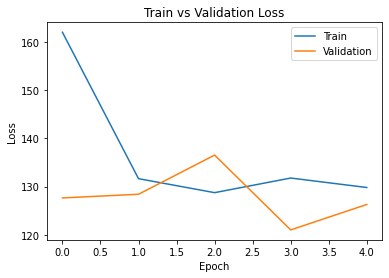

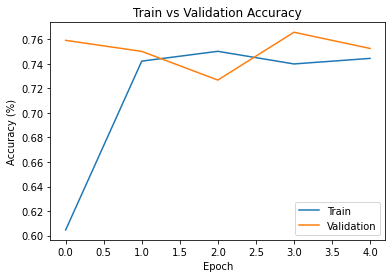

In [48]:
train3()

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

Best model was model 2 (trained with adam, no early stopping).

Validation accuracy: 79.82

Test Accuracy: 77.58